In [11]:
import math
import numpy as np
import healpy as hp
import sys
import time

#3rd party modules
from astropy.stats import jackknife_resampling
from astropy.stats import jackknife_stats
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
from astropy.constants import c
from astropy.io import fits
import getpass
from halotools.mock_observables import angular_tpcf
from scipy import integrate, interpolate
from scipy.stats import poisson
    
#Plot
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm, ticker, patches
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.colors import LogNorm
from matplotlib.patches import Ellipse
## default setting
fig_width_pt = 900                     # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

def log_10_product(x, pos):
    return '%1g' % (x)

formatter = ticker.FuncFormatter(log_10_product)
%config InlineBackend.figure_format = 'retina'

In [12]:
#Reading in the data

halos = fits.open('MICE2lightcone_halos_Mh13.5above_z0.35.fits')[1].data
print(halos.shape[0])
print(halos['z_cgal_v'])

gws = fits.open('MICE2lightcone_gwhalos_Mh12.5_z0.35.fits')[1].data
print(gws.shape[0])

rand_halos = np.load('MICE2lightcone_rand_halos_Mh13.5above_z0.35.npy')

7804244
[0.16337 0.30527 0.33748 ... 0.16761 0.1341  0.12919]
18041259


In [13]:
#compute luminosity distance versus z_red relation
cp = FlatLambdaCDM(H0=70, Om0=0.25)

numz = 501
a_zred = np.array([iz/numz for iz in range(501)])
a_dL = cp.luminosity_distance(a_zred).value

func_zred_to_dL = interpolate.InterpolatedUnivariateSpline(a_zred, a_dL)
func_dL_to_zred = interpolate.InterpolatedUnivariateSpline(a_dL, a_zred)

In [14]:
zlow = func_dL_to_zred(600)#originally at 1600
zhigh = func_dL_to_zred(800)

#selected in redshift space
mask = (gws['z_cgal_v']>=zlow) & (gws['z_cgal_v']<zhigh)
print('gw {0:4.3f} <= z_red < {1:4.3f}'.format(zlow, zhigh))
print('mean gw z_red = {0:4.3f}'.format(np.mean(gws[mask]['z_cgal_v'])))

tmp_idx = np.random.randint(1, gws[mask].shape[0], size=5100)
tmp_gws = gws[mask][tmp_idx]
print('# of selected gws = {0}'.format(tmp_gws.shape[0]))
print('# of selected halos = {0}'.format(tmp_halos.shape[0]))

gw 0.127 <= z_red < 0.166
mean gw z_red = 0.148
# of selected gws = 5100
# of selected halos = 336404


computation took 238.26200151443481 seconds


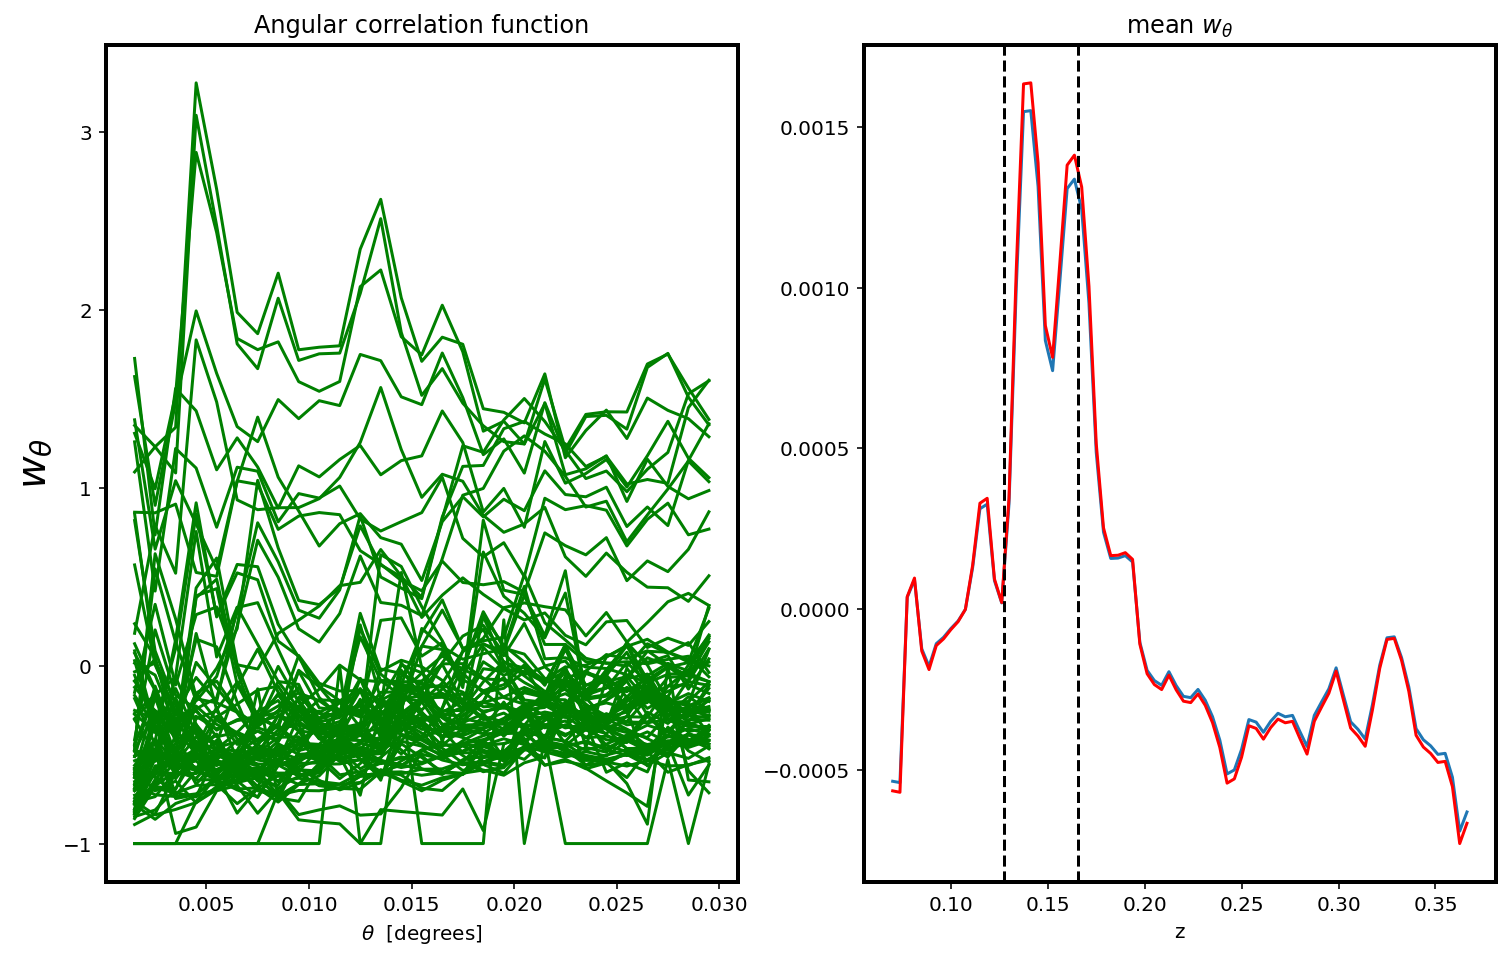

In [15]:
#creating the theta bins for TPCF
theta_bins = np.arange(.001,.031,.001)
cen_theta_bins = (theta_bins[:-1]+theta_bins[1:])/2.0
gamma = -1.6
#print("The theta bins:", theta_bins)


test_statistic = np.mean

#creating the randoms for the TPCF
def make_random_radec(num_rand):
    dtype_rand = np.dtype([('ra_gal', float), ('dec_gal', float)])
    randoms = np.zeros(shape=(num_rand), dtype=dtype_rand)

    #next assign (ra,dec)
    RA_min, RA_max = 0, np.pi/2 #[radian]pi/2 originally
    DEC_min, DEC_max = 0, np.pi/2 #[radian]pi/2 originally

    ran1_min = RA_min/2/np.pi + 0.5
    ran1_max = RA_max/2/np.pi + 0.5
    ran2_min = 0.5*np.sin(np.pi/2 - DEC_min) + 0.5
    ran2_max = 0.5*np.sin(np.pi/2 - DEC_max) + 0.5

    ran1, ran2 = np.random.random(2*num_rand).reshape(2, -1)
    ran_RA  = (ran1_max - ran1_min)*ran1 + ran1_min
    ran_DEC = (ran2_max - ran2_min)*ran2 + ran2_min #this is actually theta = pi/2 - DEC

    randoms['ra_gal'][:] = 2*np.pi*(ran_RA - 0.5)*180/np.pi #[degree]
    randoms['dec_gal'][:] = np.arcsin(2*(ran_DEC-0.5))*180/np.pi #[degree]
    #print(ran_RA)
    return randoms

rand_gws = make_random_radec(500000)
rand_halos = make_random_radec(500000)
rand_RA2 = rand_gws['ra_gal'][:]
rand_DEC2 = -rand_gws['dec_gal'][:] + 90
rand_N2 = rand_DEC2.shape[0]
rand_ang_coords = np.vstack((rand_RA2,rand_DEC2)).T

tmp_gws = tmp_gws[(tmp_gws['ra_gal']>0) & (tmp_gws['dec_gal']>0)]
RA2 = tmp_gws['ra_gal'][:] +0.5
DEC2 = -tmp_gws['dec_gal'][:] + 90
N2 = DEC2.shape[0]



t_s = time.time()
angular_coords2 = np.vstack((RA2,DEC2)).T

mean_y1 = []
mean_y2 = []
mean_x1 = []

fig, axis = plt.subplots(1,2)

for redshift in np.arange(0.07,0.37,0.00375):
    halos_mask = (halos['z_cgal_v']>=(redshift-.015)) & (halos['z_cgal_v']<redshift)
    tmp_halos = halos[halos_mask]
    tmp_halos = tmp_halos[(tmp_halos['ra_gal']>0) & (tmp_halos['dec_gal']>0)]
    RA1 = tmp_halos['ra_gal'][:]
    DEC1 = -tmp_halos['dec_gal'][:] + 90
    angular_coords1 = np.vstack((RA1,DEC1)).T
    
     
    
    ###################### VERY COOL AND GOOD TPCF ####################
    w_theta12 = angular_tpcf(angular_coords1, theta_bins, sample2=angular_coords2, randoms=rand_ang_coords, num_threads='max', do_auto=False, do_cross=True)
    
    ###################### WEIGHTED AVERAGE ###########################
    for n in range(29):
        sum_x = 0
        sum_y = 0
        div_sum1 = 0
        div_sum2 = 0
        sum_y2 = 0
        sum_x += w_theta12[n]
        sum_y += w_theta12[n]*(2*np.pi*theta_bins[n]*(theta_bins[n+1]-theta_bins[n]))
        sum_y2 += w_theta12[n]*(2*np.pi*theta_bins[n]*(theta_bins[n+1]-theta_bins[n]))*((theta_bins[n])**(gamma))
        div_sum1 += (2*np.pi*theta_bins[n]*(theta_bins[n+1]-theta_bins[n]))
        div_sum2 += (2*np.pi*theta_bins[n]*(theta_bins[n+1]-theta_bins[n]))*((theta_bins[n])**(gamma))
        
    mean_x = sum_x/.03
    mean_y = sum_y/(2*np.pi*theta_bins[29])
    #mean_y = sum_y/div_sum1
    tmp_mean_y2 = sum_y2/(2*np.pi*theta_bins[29]*(theta_bins[29])**gamma)
    #tmp_mean_y2 = sum_y2/div_sum2
    mean_x1.append(mean_x)
    mean_y1.append(mean_y)
    mean_y2.append(tmp_mean_y2)
    np.vstack(mean_x1)
    np.vstack(mean_y1)
    np.vstack(mean_y2)
    
    
    ###################### PLOT EVERYTHING ############################
    axis[0].plot(cen_theta_bins,w_theta12,'-', color='green',
         label = r'cross_corr')
    axis[0].set_ylabel(r'$w_{\theta}$', fontsize=20)
    axis[0].set_xlabel(r'$\theta$  $[{\rm degrees}]$')
    axis[0].set_title('Angular correlation function')

#axis[0,1].plot(np.arange(0.07,0.37,0.015),mean_x1)
axis[1].set_title(r'mean $w_{\theta}$')
axis[1].set_xlabel('z')
axis[1].plot(np.arange(0.07,0.37,0.00375),mean_y1)
axis[1].plot(np.arange(0.07,0.37,0.00375),mean_y2,color='red')
axis[1].axvline(x=zlow,ls='--',color='k')
axis[1].axvline(x=zhigh,ls='--',color='k')
#axis[1,1].set_title(r'mean $\theta$')
axis[1].set_xlabel('z')
t_tmp = time.time() - t_s
print('computation took {0} seconds'.format(t_tmp))
plt.savefig("wtheta_vs_z_3")

In [16]:
axis[0,1].plot(zlow, zhigh, ls='-',color='black')
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
pixel_exclude = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 64, 97, 129, 162, 194, 227, 259, 292, 324, 357, 389, 422, 454, 487, 519, 552, 584, 617, 649, 682, 714, 747, 779, 812, 844, 877, 909, 942, 974, 1007, 1039]
print(np.size(pixel_exclude))

In [ ]:
t_s = time.time()


nside = 32
halo_coords = np.column_stack((RA1,DEC1))
#assigns the appropriate pixel number to each object
pixels_halo = hp.ang2pix(nside,np.radians(RA1),np.radians(DEC1))
pixels_gws = hp.ang2pix(nside,np.radians(RA2),np.radians(DEC2))
pixels_rand = hp.ang2pix(nside,np.radians(rand_RA2),np.radians(rand_DEC2))
m = np.zeros(hp.nside2npix(nside))

np.delete(pixels_halo, pixel_exclude)
np.delete(pixels_gws, pixel_exclude)
np.delete(pixels_rand, pixel_exclude)
print (pixels_halo)

jackknife_wtheta = []

if (np.max(pixels_halo) < np.max(pixels_gws)):
    pixel_count = np.max(pixels_gws)
else:
    pixel_count = np.max(pixels_halos)
#
print(pixel_count)
print(hp.max_pixrad(nside, degrees = True))
for i in range(pixel_count):

    #creating a mask for each pixel i as to not include it in calculation
    halo_mask = np.where(pixels_halo == i)
    gws_mask = np.where(pixels_gws == i)
    rand_mask = np.where(pixels_rand == i)
    
    #applying the mask to each coordinate
    masked_RA1 = np.delete(RA1, halo_mask)
    masked_DEC1 = np.delete(DEC1, halo_mask)
    
    masked_RA2 = np.delete(RA2, gws_mask)
    masked_DEC2 = np.delete(DEC2, gws_mask)
    
    masked_rand_RA2 = np.delete(rand_RA2, rand_mask)
    masked_rand_DEC2 = np.delete(rand_DEC2, rand_mask)
    
    #creating the masked coords for the angular_tpcf function
    masked_halo_coords = np.vstack((masked_RA1,masked_DEC1)).T
    masked_gws_coords = np.vstack((masked_RA2,masked_DEC2)).T
    masked_rand_coords = np.vstack((masked_rand_RA2,masked_rand_DEC2)).T
    
    
    #jackknife_wtheta.append( angular_tpcf(masked_halo_coords, theta_bins, sample2=masked_gws_coords, randoms=masked_rand_coords, num_threads='max', do_auto=False, do_cross=True))
    
    
    
    
t_tmp = time.time() - t_s
print('computation took {0} seconds'.format(t_tmp))
#print((w_theta12_pixels))
#print(pixelated_halos)

In [ ]:
#np.savetxt("jackknife_wtheta",jackknife_wtheta)

In [ ]:
jackknife_wtheta_dat = []

f = open("jackknife_wtheta_dat", "r")
jackknife_wtheta_dat = f.read().split("\n")
f.close()
print(jackknife_wtheta_dat[0])

jackknife_wtheta = []
jackknife_mean = []
summation = 0
#x = np.split(jackknife_wtheta,6109)
x = np.array_split(jackknife_wtheta_dat,pixel_count)
j = np.arange(30)
print(j[1])
for i in range(6109):
    y = np.float128(jackknife_wtheta_dat[i].split())
    
    np.float128(jackknife_wtheta.append((np.hstack(y))))
    sum_y = 0
    samp = jackknife_wtheta[i]
    for n in range(cen_theta_bins.size):
        sum_y += samp[n]*(2*np.pi*theta_bins[n]*(theta_bins[n+1]-theta_bins[n]))
    mean_y = sum_y/(2*np.pi*theta_bins[cen_theta_bins.size])
    jackknife_mean.append(mean_y)
    
    
for j in range(len(jackknife_mean)):
    summation += jackknife_wtheta[j]
print(summation[0])
print(summation/6109)
print(jackknife_mean[1])

Number of selected halos =  15153
Freedman-Diaconis rule generates:  118 bins
delta_b =  0.0001121186440677963
sigma_k= 6.393880917845978


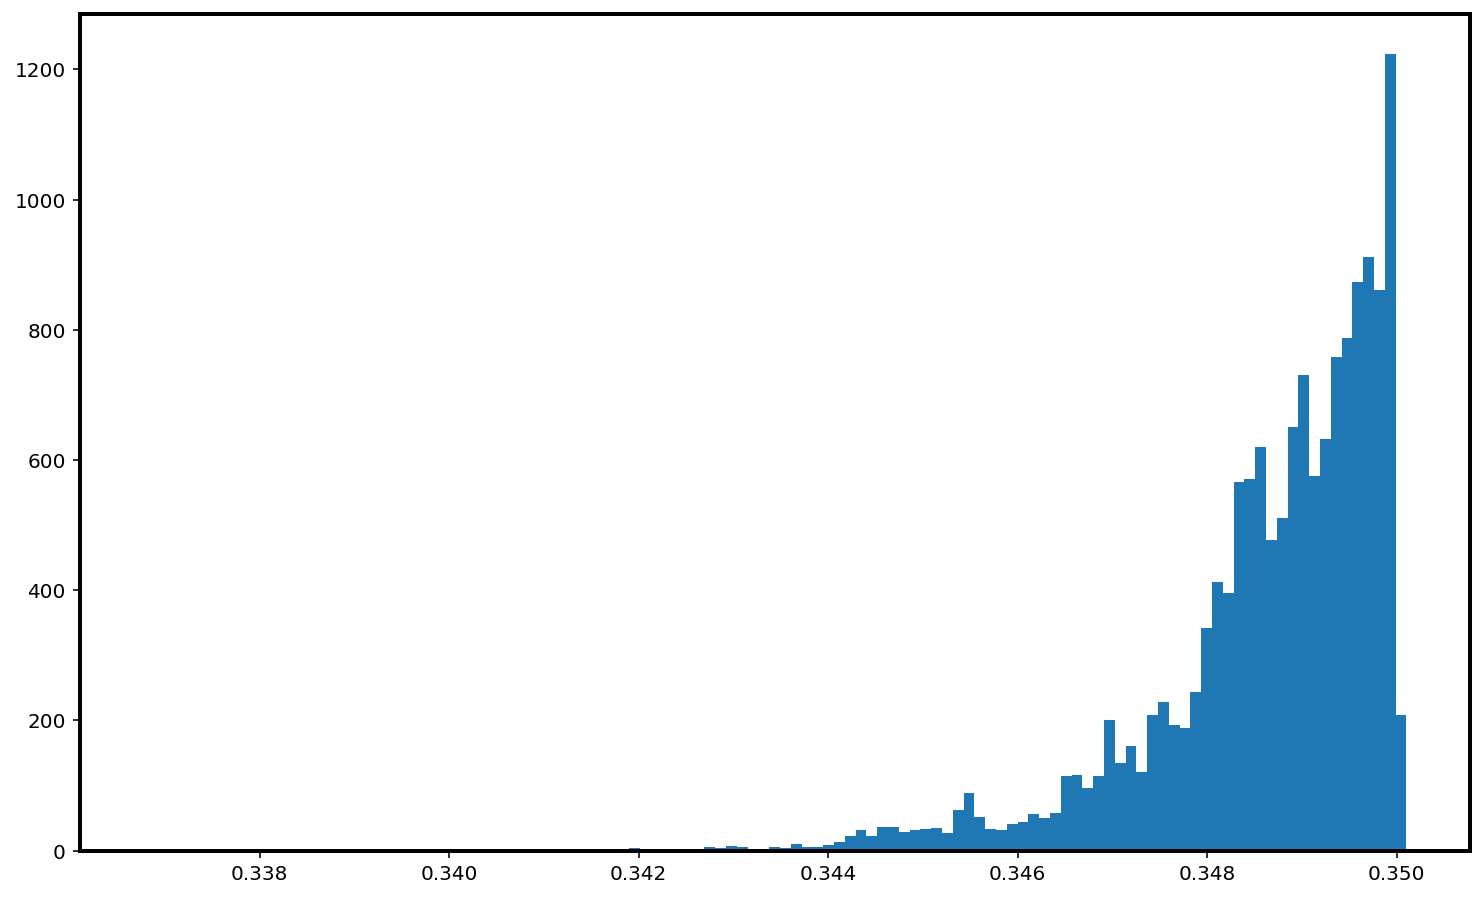

In [76]:
from astropy.visualization import hist
#hist(tmp_halos, bins='freedman')
print('Number of selected halos = ', np.size(tmp_halos))
redshift = tmp_halos.z_cgal
n_f, bins_f, patches_f = hist(redshift, bins='freedman')
print("Freedman-Diaconis rule generates: ", np.size(bins_f), "bins")
redshift_range = (np.max(redshift) - np.min(redshift))
delta_b_f = (redshift_range/np.size(bins_f))
print('delta_b = ', delta_b_f)
print('sigma_k=', np.sqrt(np.size(bins_f)) / (delta_b_f * np.size(tmp_halos)))

Knuth's rule generates:  111 bins
delta_b =  0.0001121186440677963
sigma_k= 6.201332664502232


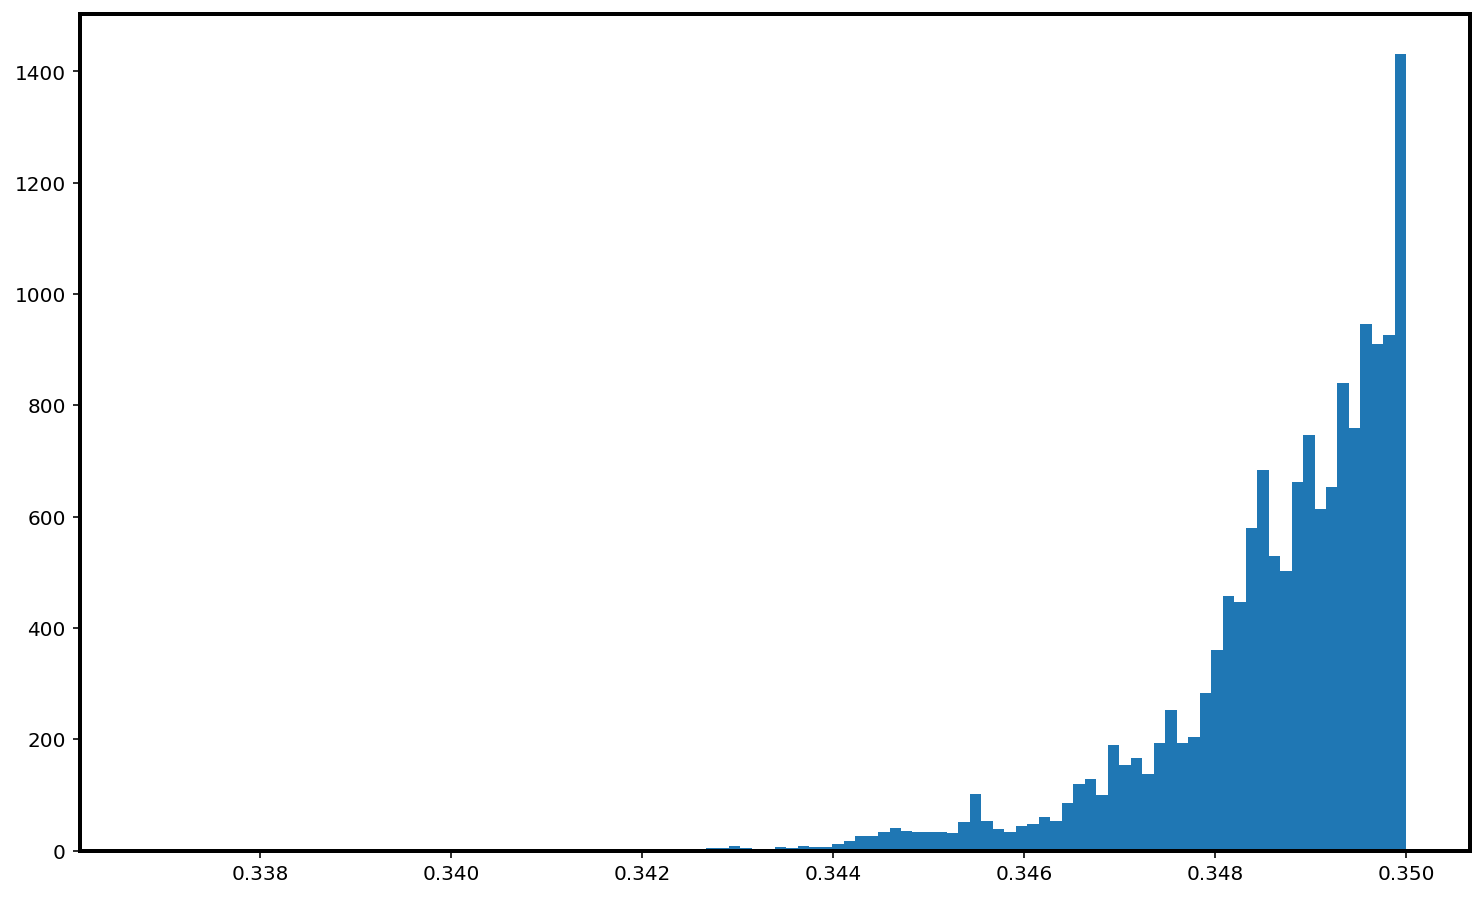

In [77]:
n_k, bins_k, patches_k = hist(redshift, bins='knuth')
print("Knuth's rule generates: ", np.size(bins_k), "bins")
delta_b_k = (redshift_range/np.size(bins_f))
print('delta_b = ', delta_b_k)
print('sigma_k=', np.sqrt(np.size(bins_k)) / (delta_b_k * np.size(tmp_halos)))

Scott's rule generates:  76 bins
delta_b =  0.0001740789473684206
sigma_k= 3.304927379520447


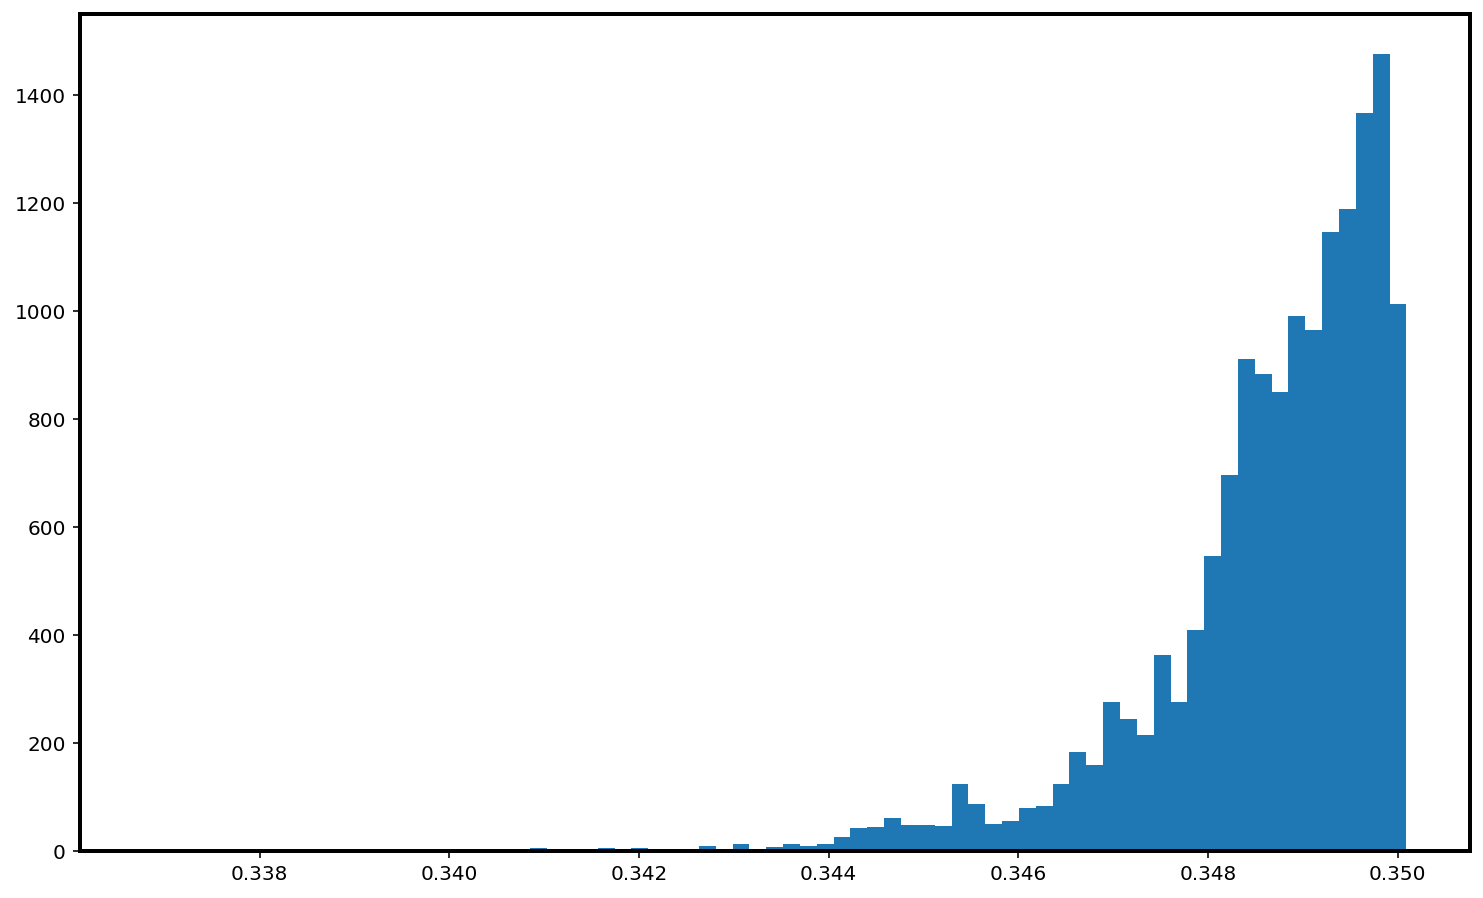

In [78]:
n_s, bins_s, patches_s = hist(redshift, bins='scott')
print("Scott's rule generates: ", np.size(bins_s), "bins")
delta_b_s = (redshift_range/np.size(bins_s))
print('delta_b = ', delta_b_s)
print('sigma_k=', np.sqrt(np.size(bins_s)) / (delta_b_s * np.size(tmp_halos)))